## Introduction
In the context of chemical and biological engineering, we deal with chemical datasets on a daily basis. Molecules can be represented in various forms, such as SMILES strings and molecular graphs. In this problem, we will walk through an example of different data representations of molecules and train a simple graph neural network (GNN) for property prediction.

#### Import Libraries

In [1]:
import random
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from rdkit import Chem
from rdkit.Chem import PandasTools
from rdkit.Chem.Draw import IPythonConsole
from IPython.display import HTML
from utils import generate_one_hot_encoding
import matplotlib.pyplot as plt
from utils import cmc_dataset, GCN, collate
from sklearn.model_selection import train_test_split
from torch.utils.data.sampler import SubsetRandomSampler

Using backend: pytorch


#### Setting Random Seed

In [2]:
seed = 2023
np.random.seed(seed)
random.seed(seed)

## Dataset

The dataframe contains the SMILES string of each surfactant monomer as well as its corresponding log CMC value. Below, we show several examples of the surfactant monomer and their corresponding data representations.

In [3]:
df = pd.read_csv("./Data/cmc_metadata.csv")

#### SMILES, Molecular Structure (Graph), and One-hot-encoded Matrix

,SMILES,logCMC,Structure
0,CCCCCCCCC(O)CO,3.361728,
1,CCCCCCCCC(O)CCO,3.361728,
2,CCCCCCCCCCCCC(O)CCO,1.113943,

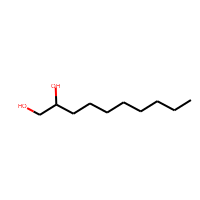
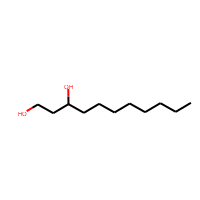
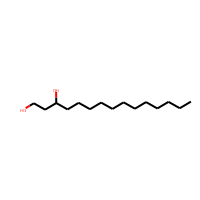

In [4]:
sample_id = [0,1,2]
PandasTools.AddMoleculeColumnToFrame(df, "SMILES", "Structure")
HTML(df.iloc[sample_id].to_html(notebook=True))

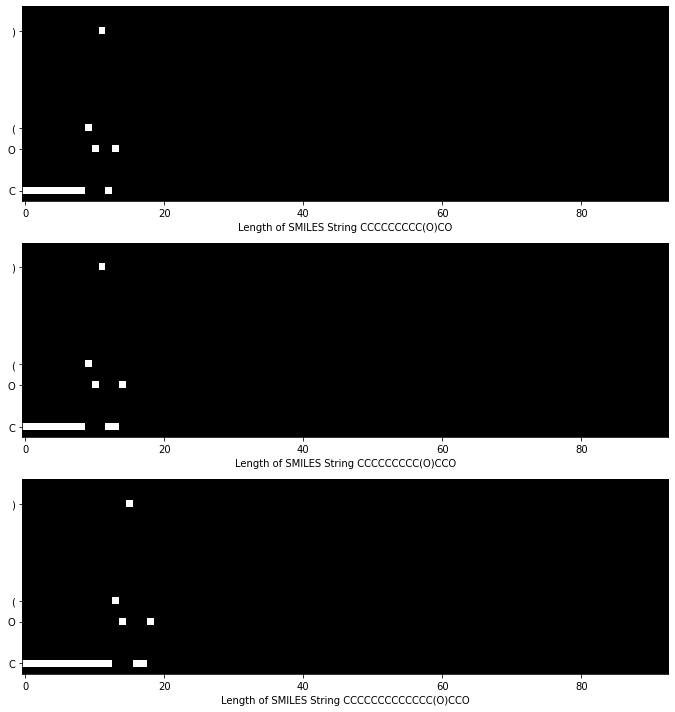

In [5]:
ohe, smi2index, smiles_maxlen = generate_one_hot_encoding(df)
idx = [smi2index[char] for char in ["C", "O", "(", ")"]]
fig, ax = plt.subplots(3,1,figsize=(10,10))
for i in sample_id:
    ax[i].imshow(ohe[i], cmap="gray")
    ax[i].set_xlabel("Length of SMILES String {}".format(df.SMILES.iloc[i]))
    ax[i].set_yticks(idx, [list(smi2index.keys())[x] for x in idx])
plt.tight_layout()

## Train a GNN Model

#### Model Setup and Training

In [6]:
batch_size = 5
cmc_data = cmc_dataset()
train_idx, test_idx = train_test_split(range(len(cmc_data)), test_size=0.1, random_state=seed, shuffle=True)
train_sampler = SubsetRandomSampler(train_idx)
test_sampler = SubsetRandomSampler(test_idx)
train_loader = torch.utils.data.DataLoader(cmc_data, batch_size=batch_size,
                                            sampler=train_sampler,
                                            collate_fn=collate,
                                            shuffle=False,
                                            drop_last=False)
test_loader = torch.utils.data.DataLoader(cmc_data, batch_size=batch_size,
                                            sampler=test_sampler,
                                            collate_fn=collate,
                                            shuffle=False,
                                            drop_last=False)

In [65]:
model = GCN(74, 256, 1)
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(params=model.parameters())

In [66]:
n_epoch = 50
train_losses = []
test_losses = []
for epoch in range(n_epoch):
    cur_train_loss = 0
    model.train()
    for data in train_loader:
        batched_graph = data[0] 
        labels = data[1]
        optimizer.zero_grad()
        pred = model(batched_graph, batched_graph.ndata['h'].float())
        loss = loss_fn(pred, labels)
        cur_train_loss += loss_fn(pred, labels).item()
        loss.backward()
        optimizer.step()
    avg_train_loss = cur_train_loss/len(train_loader)
    train_losses.append(avg_train_loss)
    cur_test_loss = 0
    model.eval()
    for data in test_loader:
        batched_graph = data[0] 
        labels = data[1]
        pred = model(batched_graph, batched_graph.ndata['h'].float())
        loss = loss_fn(pred, labels)
        cur_test_loss += loss.item()
    avg_test_loss = cur_test_loss/len(test_loader)
    test_losses.append(avg_test_loss)
    print("Epoch {}, train loss {:.3f}, test loss {:.3f}".format(epoch+1, avg_train_loss, avg_test_loss))


Epoch 1, train loss 4.397, test loss 2.060
Epoch 2, train loss 1.365, test loss 1.715
Epoch 3, train loss 1.246, test loss 1.408
Epoch 4, train loss 1.432, test loss 1.152
Epoch 5, train loss 1.140, test loss 1.007
Epoch 6, train loss 1.025, test loss 1.023
Epoch 7, train loss 0.974, test loss 1.027
Epoch 8, train loss 0.943, test loss 0.987
Epoch 9, train loss 0.922, test loss 0.926
Epoch 10, train loss 0.935, test loss 1.140
Epoch 11, train loss 0.950, test loss 0.955
Epoch 12, train loss 0.958, test loss 0.819
Epoch 13, train loss 0.938, test loss 0.941
Epoch 14, train loss 0.869, test loss 1.085
Epoch 15, train loss 0.791, test loss 0.772
Epoch 16, train loss 0.788, test loss 0.765
Epoch 17, train loss 0.822, test loss 0.812
Epoch 18, train loss 0.835, test loss 0.904
Epoch 19, train loss 0.832, test loss 1.470
Epoch 20, train loss 0.858, test loss 0.855
Epoch 21, train loss 0.749, test loss 0.950
Epoch 22, train loss 0.735, test loss 0.920
Epoch 23, train loss 0.756, test loss 0.7

#### Convergence

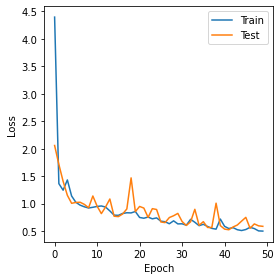

In [74]:
fig, ax = plt.subplots(figsize=(4,4))
ax.plot(np.arange(n_epoch), train_losses, label="Train")
ax.plot(np.arange(n_epoch), test_losses, label="Test")
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
plt.legend()
plt.tight_layout()

#### Predict and Parity Plot

In [69]:
true_train, pred_train = [], []
true_test, pred_test = [], []
for idx in range(len(cmc_data)):
    data = cmc_data[idx]
    if idx in train_idx:
        true_train.append(data[1].cpu().unsqueeze(-1).numpy()[0])
        pred_train.append(model(data[0], data[0].ndata["h"]).detach().cpu().numpy()[0][0])
    else:
        true_test.append(data[1].cpu().unsqueeze(-1).numpy()[0])
        pred_test.append(model(data[0], data[0].ndata["h"]).detach().cpu().numpy()[0][0])

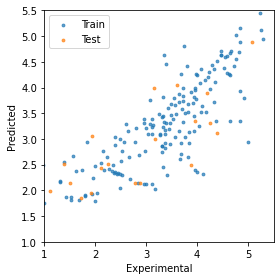

In [73]:
fig, ax = plt.subplots(figsize=(4,4))
ax.scatter(true_train, pred_train, label="Train", alpha=0.7, s=8)
ax.scatter(true_test, pred_test, label="Test", alpha=0.7, s=8)
ax.set_xlim([1,5.5])
ax.set_ylim([1,5.5])
ax.set_xlabel("Experimental")
ax.set_ylabel("Predicted")
plt.legend()
plt.tight_layout()